In [ ]:
!pip install opencv-python numpy datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 28.4 MB/s 
     |████████████████████████████████| 115 kB 72.0 MB/s 
     |████████████████████████████████| 212 kB 79.3 MB/s 
     |████████████████████████████████| 163 kB 93.5 MB/s 
     |████████████████████████████████| 127 kB 57.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
from datasets import load_dataset

data = load_dataset('pinecone/image-set',split='train',revision='e7d39fc')
data

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/pinecone___json/pinecone--image-set-b126889730929864/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab. Subsequent calls will reuse this data.


Dataset({
    features: ['image_bytes', 'image'],
    num_rows: 21
})

In [ ]:
from base64 import b64decode
import cv2
import numpy as np

def process_fn(sample):
    image_bytes = b64decode(sample['image_bytes'])
    image = cv2.imdecode(np.frombuffer(image_bytes, np.uint8), cv2.IMREAD_COLOR)
    return image

In [ ]:
images = [process_fn(sample) for sample in data]

In [ ]:
len(images)

21

In [ ]:
images[1].shape

(1537, 2532, 3)

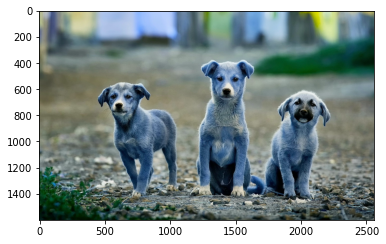

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(images[0]) #BGR

In [ ]:
shape = images[0].shape
shape, images[0][0, 0, :]

((1600, 2560, 3), array([165, 174, 134], dtype=uint8))

In [ ]:
import numpy as np

rgb_image = np.flip(images[0], 2)

shape = rgb_image.shape
shape, rgb_image[0, 0, :]

((1600, 2560, 3), array([134, 174, 165], dtype=uint8))

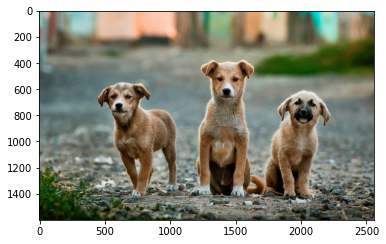

In [ ]:
plt.imshow(rgb_image)


In [ ]:
red_hist = cv2.calcHist(
    [images[5]], [2], None, [64], [0, 256]
)
green_hist = cv2.calcHist(
    [images[5]], [1], None, [64], [0, 256]
)
blue_hist = cv2.calcHist(
    [images[5]], [0], None, [64], [0, 256]
)

red_hist.shape

(64, 1)

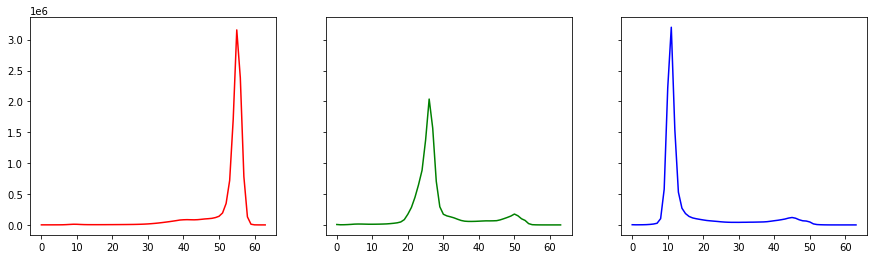

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
axs[0].plot(red_hist, color='r')
axs[1].plot(green_hist, color='g')
axs[2].plot(blue_hist, color='b')
plt.show()

In [ ]:
def get_vector(image, bins=32):
    red = cv2.calcHist(
        [image], [2], None, [bins], [0, 256]
    )
    green = cv2.calcHist(
        [image], [1], None, [bins], [0, 256]
    )
    blue = cv2.calcHist(
        [image], [0], None, [bins], [0, 256]
    )
    vector = np.concatenate([red, green, blue], axis=0)
    vector = vector.reshape(-1)
    return vector

In [ ]:
vec = get_vector(images[0])
vec.shape

(96,)

In [ ]:
image_vectors = []
for image in images:
    image_vectors.append(get_vector(image))

In [ ]:
def cosine(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [ ]:
rgb_images = np.array([np.flip(image, 2) for image in images])

def search(idx, top_k=5):
    query_vector = image_vectors[idx]
    distances = []
    for _, vector in enumerate(image_vectors):
        distances.append(cosine(query_vector, vector))
    # get top k most similar images
    top_idx = np.argpartition(distances, -top_k)[-top_k:]
    return top_idx

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [ ]:
search(0)

array([ 3, 18, 14, 15,  0])

In [ ]:
def visualize(query_i, results_i):
    query = rgb_images[query_i]
    span = int(len(image_vectors[0])/3)
    results = rgb_images[results_i]
    top_k = len(results)
    # visualize query image and it's color histogram
    fig, axs = plt.subplots(1, 2, figsize=(18, 10))
    axs[0].imshow(query)
    axs[0].axis('off')
    axs[1].plot(image_vectors[query_i][:span], 'r', label='red')
    axs[1].plot(image_vectors[query_i][span:span*2], 'g', label='green')
    axs[1].plot(image_vectors[query_i][span*2:], 'b', label='blue')
    plt.show()
    # visualize top k images and their color histograms
    fig0, axs0 = plt.subplots(1, top_k, figsize=(top_k*5, 5))
    fig1, axs1 = plt.subplots(1, top_k, figsize=(top_k*5, 5), sharey=True)
    for i in range(top_k):
        axs0[i].imshow(results[i])
        axs0[i].axis('off')
        axs1[i].plot(image_vectors[results_i[i]][:span], 'r', label='red')
        axs1[i].plot(image_vectors[results_i[i]][span:span*2], 'g', label='green')
        axs1[i].plot(image_vectors[results_i[i]][span*2:], 'b', label='blue')

In [ ]:
results_i = search(0)

In [ ]:
results_i


array([ 3, 18, 14, 15,  0])

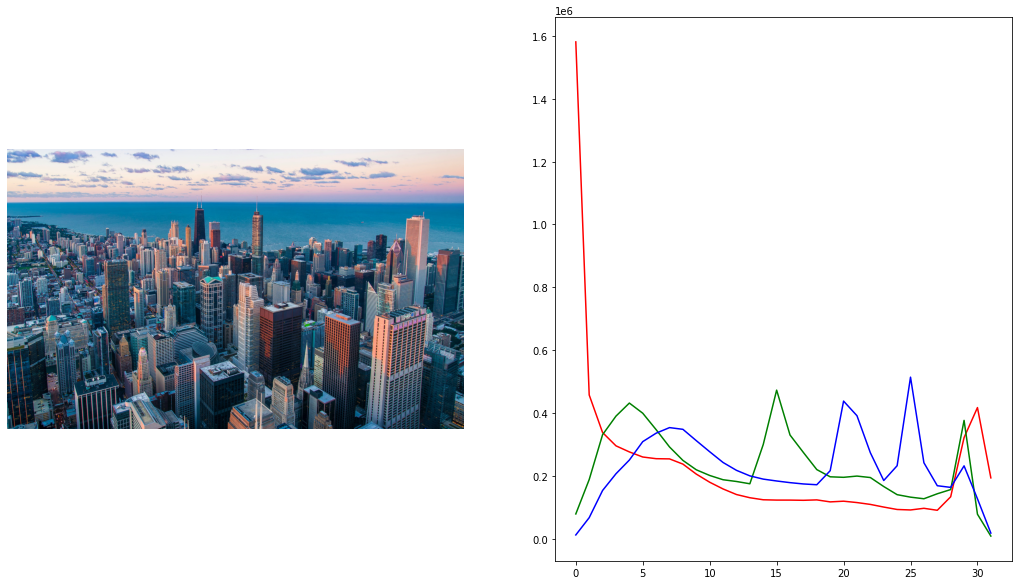

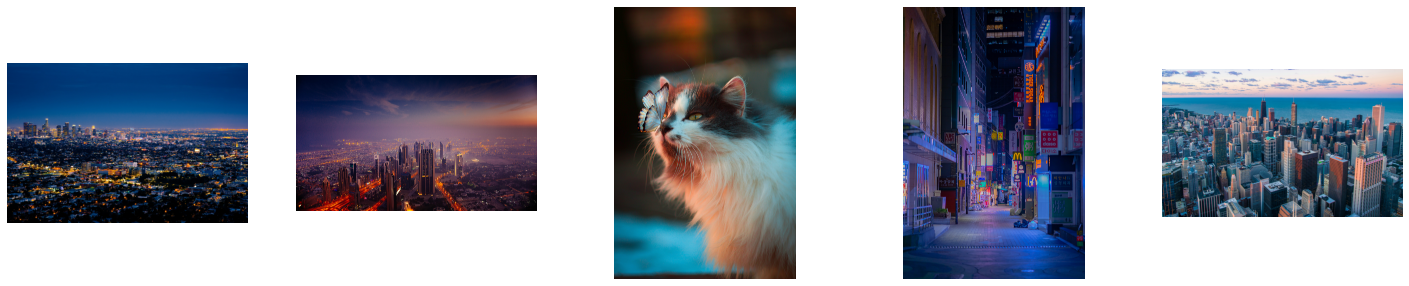

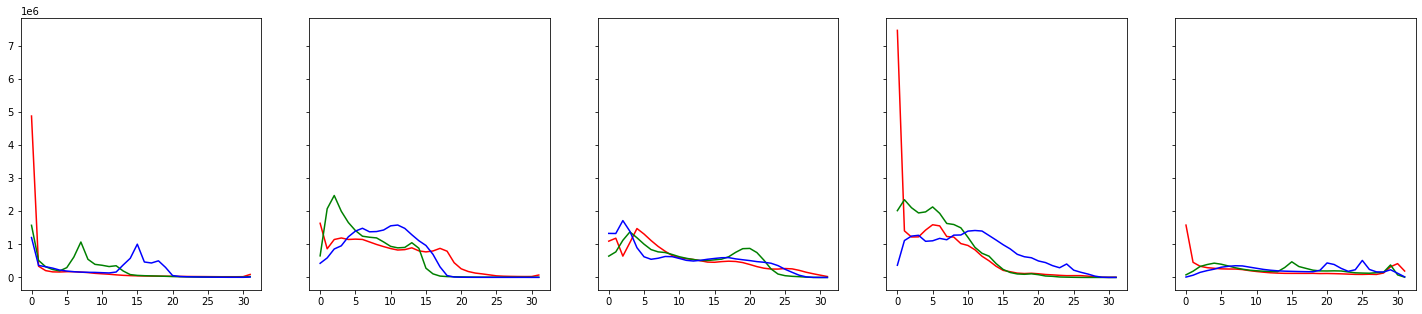

In [ ]:
img = 6
visualize(img, search(img))

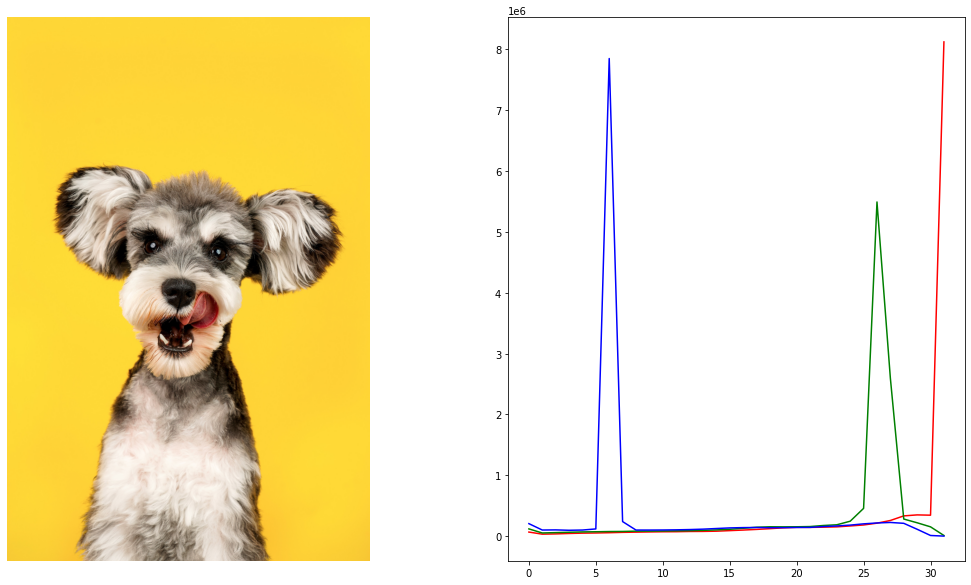

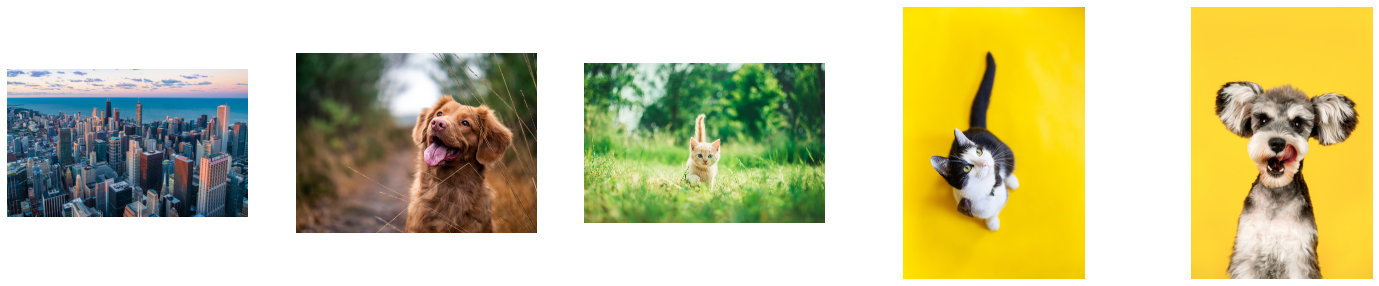

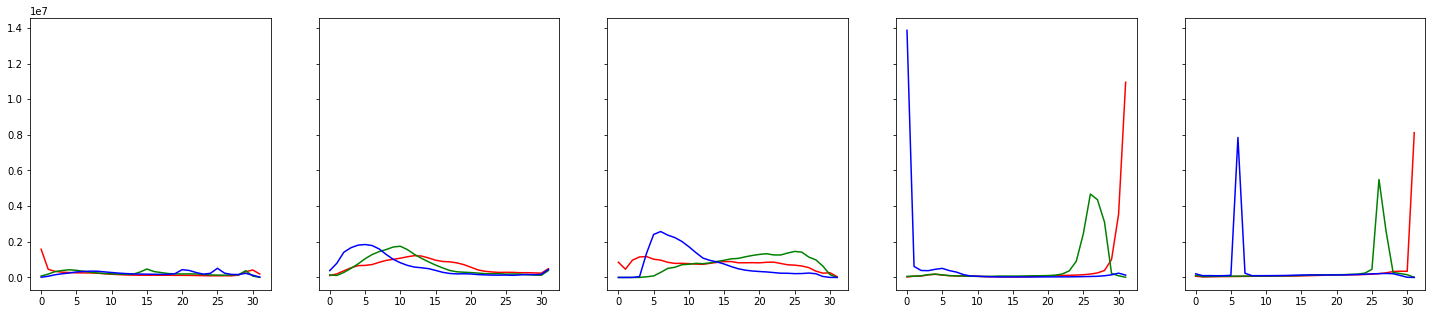

In [ ]:
img = 10
visualize(img, search(img))

In [ ]:
image_vectors = []
for image in images:
    image_vectors.append(get_vector(image, bins=256))

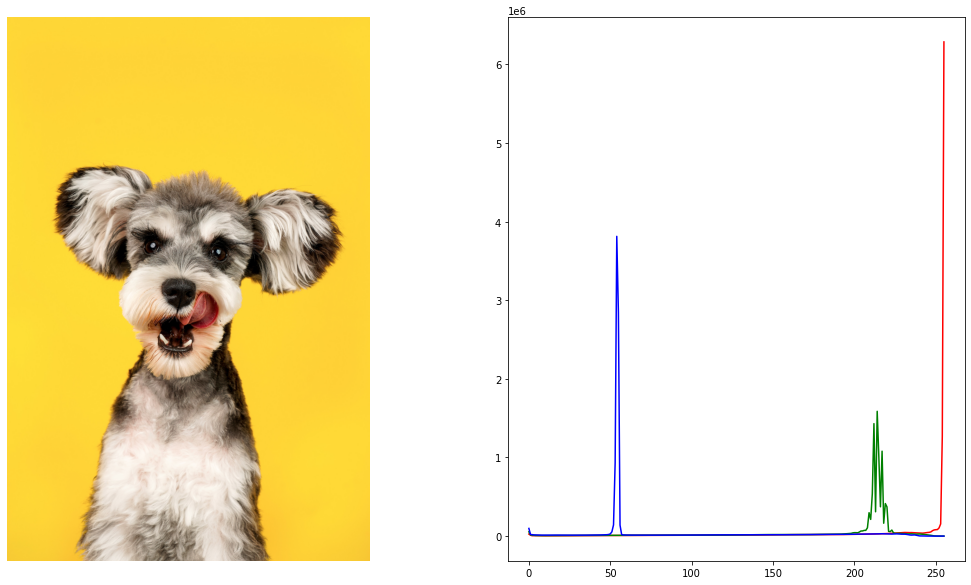

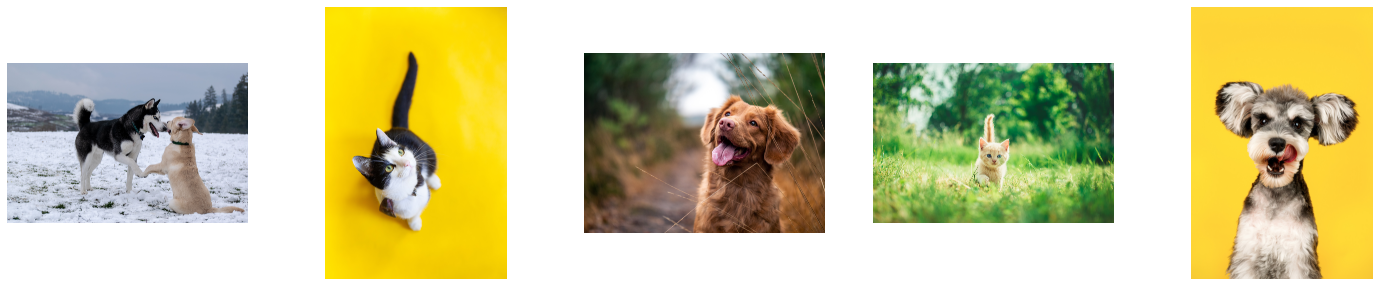

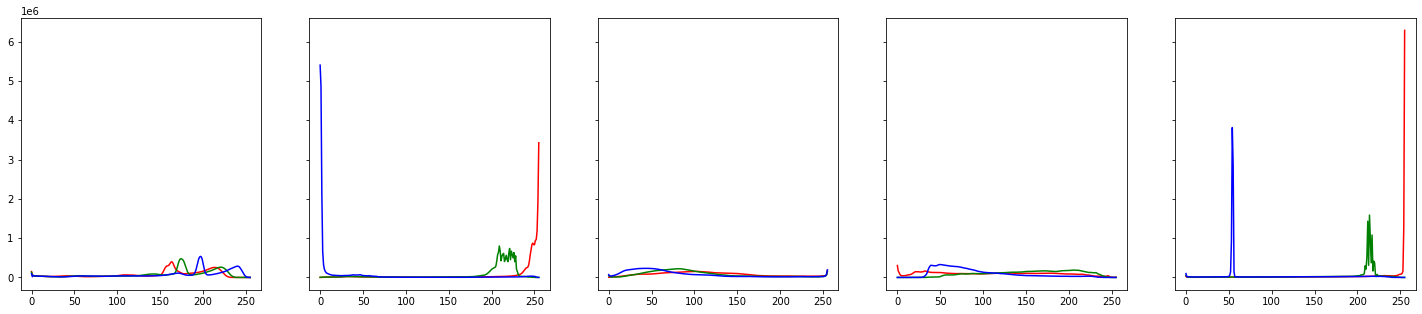

In [ ]:
img = 10
visualize(img, search(img))